# Azure Model Evaluation On Stutterance

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stutterance count
4. Get Error & Stutterance Type ==> show which stutterance type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

*** 

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stutterance Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [3]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """
    
    candidate_tokens = list(candidate)
    reference_tokens = list(reference)
    
    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)
    
    dist_mat = np.zeros((ref_len, cand_len), dtype=int)
    
    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j
        
    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1
                
            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)
            
    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion (Azure)

In [4]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [5]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_azure = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Azure.csv", delimiter=",")

del net_aigenerated_data_azure[net_aigenerated_data_azure.columns[0]]

In [6]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [7]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [8]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [9]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...
1,D0001_A,790.130000,796.580000,电视剧。
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？
3,D0001_A,2016.780000,2035.673559,很很精准，对。
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_azure`**

***

## Azure WER Analysis

In [10]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_azure.iterrows(), total=len(net_aigenerated_data_azure)):
    
    mask_large = (
        (net_aigenerated_data_azure["Filename"] == row["Filename"]) &
        (net_aigenerated_data_azure["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_azure.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    azure = large_row["Azure"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(azure) or not isinstance(azure, str):
        print("Skipping due to missing or non-string Azure.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(azure, cleaned_transcript)
        
        net_aigenerated_data_azure.loc[mask_large, "WER"] = wer_value
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"] = stutterance_count

        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_azure = net_aigenerated_data_azure.assign(NA_Count=na_count_large)
net_aigenerated_data_azure = net_aigenerated_data_azure.assign(NA_Cleaned_Count=na_count_cleaned)

  0%|          | 46/37253 [00:00<04:05, 151.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 79/37253 [00:00<03:58, 155.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 129/37253 [00:00<04:08, 149.32it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 178/37253 [00:01<04:03, 152.04it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 797/37253 [00:05<03:59, 151.95it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 893/37253 [00:06<03:58, 152.36it/s]

Skipping due to missing or non-string Azure.


  4%|▎         | 1347/37253 [00:09<04:19, 138.46it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1522/37253 [00:10<04:12, 141.24it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1656/37253 [00:11<04:05, 144.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1704/37253 [00:11<03:53, 152.07it/s]

Skipping due to missing or non-string Azure.


  5%|▍         | 1856/37253 [00:12<03:58, 148.54it/s]

Skipping: One of the rows is empty.


  5%|▌         | 1980/37253 [00:13<04:06, 143.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▌         | 2026/37253 [00:13<04:02, 145.52it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2087/37253 [00:14<04:05, 143.44it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2166/37253 [00:14<03:50, 151.91it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2214/37253 [00:15<03:53, 150.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2262/37253 [00:15<03:58, 146.98it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2488/37253 [00:17<04:05, 141.84it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2565/37253 [00:17<03:52, 149.49it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2662/37253 [00:18<03:48, 151.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  7%|▋         | 2693/37253 [00:18<03:53, 147.93it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  8%|▊         | 2829/37253 [00:19<04:33, 125.82it/s]

Skipping due to missing or non-string Azure.


  9%|▊         | 3224/37253 [00:22<04:34, 124.15it/s]

Skipping due to missing or non-string Azure.


  9%|▉         | 3484/37253 [00:24<04:56, 113.96it/s]

Skipping due to missing or non-string Azure.


 10%|▉         | 3723/37253 [00:26<03:33, 157.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3774/37253 [00:26<03:25, 162.77it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3807/37253 [00:26<03:32, 157.11it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3858/37253 [00:27<03:25, 162.31it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4009/37253 [00:28<03:21, 164.90it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4043/37253 [00:28<03:20, 165.75it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4077/37253 [00:28<03:22, 163.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4130/37253 [00:28<03:17, 167.66it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4183/37253 [00:29<03:14, 169.61it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4217/37253 [00:29<03:36, 152.64it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4280/37253 [00:29<03:50, 143.17it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4309/37253 [00:30<04:01, 136.17it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4338/37253 [00:30<04:04, 134.77it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4397/37253 [00:30<03:54, 140.03it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4431/37253 [00:30<03:34, 152.94it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4604/37253 [00:31<03:20, 162.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4638/37253 [00:32<03:27, 157.20it/s]

Skipping due to missing or non-string Azure.


 13%|█▎        | 4689/37253 [00:32<03:20, 162.65it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 13%|█▎        | 4937/37253 [00:34<03:33, 151.36it/s]

Skipping due to missing or non-string Azure.


 14%|█▎        | 5053/37253 [00:34<03:17, 163.02it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▎        | 5105/37253 [00:35<03:11, 167.99it/s]

Skipping due to missing or non-string Azure.


 14%|█▍        | 5173/37253 [00:35<03:27, 154.39it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▍        | 5328/37253 [00:36<03:38, 146.31it/s]

Skipping due to missing or non-string Azure.


 15%|█▍        | 5441/37253 [00:37<03:32, 149.51it/s]

Skipping due to missing or non-string Azure.


 15%|█▌        | 5760/37253 [00:39<04:29, 116.77it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▌        | 5843/37253 [00:40<04:01, 129.95it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5870/37253 [00:40<04:09, 125.87it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5918/37253 [00:41<03:34, 145.95it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5966/37253 [00:41<03:28, 150.26it/s]

Skipping due to missing or non-string Azure.


 16%|█▋        | 6072/37253 [00:42<03:35, 144.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▋        | 6102/37253 [00:42<03:36, 143.76it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6147/37253 [00:42<03:40, 140.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6209/37253 [00:43<03:33, 145.70it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6258/37253 [00:43<03:24, 151.74it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6294/37253 [00:43<03:11, 161.93it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6389/37253 [00:44<03:41, 139.24it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6533/37253 [00:45<03:47, 135.19it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6579/37253 [00:45<03:29, 146.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 18%|█▊        | 6754/37253 [00:46<03:48, 133.59it/s]

Skipping due to missing or non-string Azure.


 19%|█▊        | 6917/37253 [00:48<03:29, 144.69it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 6998/37253 [00:48<03:16, 154.14it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 19%|█▉        | 7165/37253 [00:49<03:05, 162.49it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 7231/37253 [00:50<03:17, 151.88it/s]

Skipping due to missing or non-string Azure.


 20%|█▉        | 7392/37253 [00:51<03:39, 136.13it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7467/37253 [00:51<03:31, 141.03it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7543/37253 [00:52<03:26, 143.91it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7574/37253 [00:52<03:23, 146.01it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7721/37253 [00:53<03:25, 143.48it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7873/37253 [00:54<03:36, 135.61it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 21%|██        | 7904/37253 [00:55<03:25, 142.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 21%|██▏       | 7965/37253 [00:55<03:18, 147.27it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8075/37253 [00:56<03:06, 156.06it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8126/37253 [00:56<03:01, 160.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8192/37253 [00:56<03:07, 155.31it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8241/37253 [00:57<03:09, 153.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8288/37253 [00:57<03:26, 140.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8333/37253 [00:57<03:27, 139.47it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8364/37253 [00:58<03:18, 145.36it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8395/37253 [00:58<03:17, 146.06it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8528/37253 [00:59<02:57, 161.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8625/37253 [00:59<03:10, 150.01it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 24%|██▎       | 8790/37253 [01:01<03:47, 125.28it/s]

Skipping due to missing or non-string Azure.


 24%|██▎       | 8844/37253 [01:01<03:48, 124.46it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 8968/37253 [01:02<03:26, 136.69it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 9040/37253 [01:02<03:21, 140.17it/s]

Skipping due to missing or non-string Azure.


 25%|██▍       | 9218/37253 [01:04<02:57, 157.61it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 25%|██▌       | 9373/37253 [01:05<03:32, 131.23it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 26%|██▌       | 9514/37253 [01:06<03:03, 151.48it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9629/37253 [01:06<03:04, 149.82it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9693/37253 [01:07<03:03, 150.33it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9773/37253 [01:07<03:00, 152.34it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9804/37253 [01:08<03:06, 146.98it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9850/37253 [01:08<03:07, 146.00it/s]

Skipping due to missing or non-string Azure.


 27%|██▋       | 9943/37253 [01:09<02:59, 152.42it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10095/37253 [01:09<02:42, 166.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10312/37253 [01:11<02:49, 159.39it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10364/37253 [01:11<02:43, 164.79it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10417/37253 [01:12<02:47, 159.83it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10466/37253 [01:12<03:03, 145.59it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10496/37253 [01:12<03:13, 138.23it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▊       | 10623/37253 [01:13<02:53, 153.90it/s]

Skipping due to missing or non-string Azure.


 29%|██▊       | 10672/37253 [01:13<02:49, 156.95it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▊       | 10707/37253 [01:13<02:41, 164.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10822/37253 [01:14<02:48, 156.80it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10876/37253 [01:15<02:35, 169.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10912/37253 [01:15<02:38, 166.39it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10946/37253 [01:15<02:47, 156.61it/s]

Skipping due to missing or non-string Azure.


 30%|███       | 11187/37253 [01:17<02:56, 147.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11281/37253 [01:17<02:53, 149.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11314/37253 [01:17<02:47, 154.67it/s]

Skipping due to missing or non-string Azure.


 30%|███       | 11346/37253 [01:18<02:47, 154.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11510/37253 [01:19<02:41, 159.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11560/37253 [01:19<02:41, 159.29it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11592/37253 [01:19<02:52, 148.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11638/37253 [01:20<02:59, 142.93it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 11742/37253 [01:20<02:59, 141.86it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 11981/37253 [01:22<02:46, 151.67it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 12063/37253 [01:22<02:41, 156.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12186/37253 [01:23<02:59, 139.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12217/37253 [01:24<02:54, 143.52it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12265/37253 [01:24<02:46, 149.83it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12311/37253 [01:24<02:50, 146.65it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12390/37253 [01:25<02:40, 154.93it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12423/37253 [01:25<02:38, 156.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12475/37253 [01:25<02:31, 163.44it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12642/37253 [01:26<02:37, 156.34it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12692/37253 [01:27<02:34, 159.26it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12772/37253 [01:27<02:49, 144.14it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12818/37253 [01:27<02:53, 140.79it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12862/37253 [01:28<02:57, 137.56it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12910/37253 [01:28<02:43, 149.18it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12941/37253 [01:28<02:49, 143.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12987/37253 [01:29<02:49, 143.54it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13049/37253 [01:29<02:48, 144.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▌      | 13110/37253 [01:29<02:48, 143.16it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13156/37253 [01:30<02:44, 146.24it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13233/37253 [01:30<02:47, 143.21it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13451/37253 [01:32<02:41, 147.73it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13517/37253 [01:32<02:29, 158.74it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▋      | 13550/37253 [01:32<02:27, 160.33it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 37%|███▋      | 13735/37253 [01:34<02:44, 142.56it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 37%|███▋      | 13799/37253 [01:34<02:39, 146.90it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13861/37253 [01:35<02:40, 146.17it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 13985/37253 [01:36<03:05, 125.31it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14050/37253 [01:36<02:32, 152.13it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14136/37253 [01:37<02:24, 159.65it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14223/37253 [01:37<02:18, 166.29it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14273/37253 [01:37<02:28, 155.12it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14306/37253 [01:38<02:27, 155.60it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14338/37253 [01:38<02:32, 150.28it/s]

Skipping due to missing or non-string Azure.


 39%|███▊      | 14385/37253 [01:38<02:35, 147.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14450/37253 [01:39<02:27, 154.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14483/37253 [01:39<02:27, 154.42it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14499/37253 [01:39<02:36, 145.66it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14679/37253 [01:40<02:28, 152.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14745/37253 [01:41<02:20, 159.76it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14848/37253 [01:41<02:32, 146.76it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14878/37253 [01:41<02:38, 140.95it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 14952/37253 [01:42<02:37, 142.02it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 15028/37253 [01:42<02:32, 146.00it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15141/37253 [01:43<02:20, 157.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15235/37253 [01:44<02:02, 179.14it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15311/37253 [01:44<02:00, 182.52it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15349/37253 [01:44<02:00, 182.52it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████▏     | 15387/37253 [01:45<01:59, 182.97it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15482/37253 [01:45<01:59, 182.32it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15539/37253 [01:45<01:58, 182.52it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15672/37253 [01:46<01:57, 182.93it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15710/37253 [01:46<01:59, 179.95it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 15988/37253 [01:48<01:58, 179.73it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16043/37253 [01:48<01:58, 178.42it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16098/37253 [01:49<01:58, 178.79it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16193/37253 [01:49<01:58, 177.88it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16326/37253 [01:50<01:56, 180.08it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16402/37253 [01:50<01:54, 181.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 44%|████▍     | 16477/37253 [01:51<01:57, 176.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▍     | 16747/37253 [01:52<01:57, 173.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▌     | 16783/37253 [01:52<02:00, 169.36it/s]

Skipping due to missing or non-string Azure.


 45%|████▌     | 16854/37253 [01:53<01:58, 172.00it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 16962/37253 [01:53<01:57, 172.81it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17161/37253 [01:55<01:52, 178.07it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 46%|████▌     | 17197/37253 [01:55<01:52, 177.99it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17485/37253 [01:56<01:54, 172.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17539/37253 [01:57<01:55, 171.10it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17593/37253 [01:57<01:55, 170.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17629/37253 [01:57<01:54, 170.81it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17719/37253 [01:58<01:52, 173.58it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17828/37253 [01:58<01:49, 177.20it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17864/37253 [01:59<01:49, 176.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17918/37253 [01:59<01:48, 178.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▊     | 18082/37253 [02:00<01:48, 177.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▉     | 18208/37253 [02:01<01:50, 172.77it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18316/37253 [02:01<01:47, 175.61it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18389/37253 [02:02<01:46, 177.38it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18479/37253 [02:02<01:45, 177.15it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18534/37253 [02:02<01:45, 177.63it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18588/37253 [02:03<01:45, 176.45it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18642/37253 [02:03<01:44, 177.59it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18751/37253 [02:04<01:43, 178.42it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 50%|█████     | 18787/37253 [02:04<01:45, 175.56it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18877/37253 [02:04<01:44, 176.51it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18967/37253 [02:05<01:43, 177.28it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 19040/37253 [02:05<01:42, 178.06it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19096/37253 [02:06<01:41, 178.76it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19168/37253 [02:06<01:41, 177.35it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19258/37253 [02:07<01:42, 175.86it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19331/37253 [02:07<01:41, 177.32it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19603/37253 [02:09<01:39, 177.50it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19675/37253 [02:09<01:39, 177.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19729/37253 [02:09<01:39, 177.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19893/37253 [02:10<01:37, 178.26it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19965/37253 [02:11<01:38, 175.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20038/37253 [02:11<01:36, 177.94it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20092/37253 [02:11<01:37, 175.40it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20239/37253 [02:12<01:35, 178.84it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20293/37253 [02:12<01:34, 178.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▍    | 20367/37253 [02:13<01:34, 177.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20497/37253 [02:14<01:33, 180.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20642/37253 [02:14<01:38, 169.45it/s]

Skipping due to missing or non-string Azure.


 56%|█████▋    | 21003/37253 [02:16<01:31, 177.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21058/37253 [02:17<01:31, 177.15it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21112/37253 [02:17<01:31, 176.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21239/37253 [02:18<01:30, 176.62it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21311/37253 [02:18<01:31, 173.74it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21458/37253 [02:19<01:28, 177.98it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21550/37253 [02:20<01:27, 179.77it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 58%|█████▊    | 21731/37253 [02:21<01:27, 177.67it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21785/37253 [02:21<01:27, 177.29it/s]

Skipping due to missing or non-string Azure.


 59%|█████▊    | 21859/37253 [02:21<01:26, 178.42it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21913/37253 [02:22<01:26, 177.46it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21985/37253 [02:22<01:26, 176.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22021/37253 [02:22<01:27, 174.62it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22094/37253 [02:23<01:25, 177.54it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22130/37253 [02:23<01:25, 176.18it/s]

Skipping due to missing or non-string Azure.


 60%|█████▉    | 22282/37253 [02:24<01:20, 185.30it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22415/37253 [02:24<01:20, 184.68it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22529/37253 [02:25<01:20, 183.67it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22734/37253 [02:26<01:21, 177.68it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 61%|██████▏   | 22825/37253 [02:27<01:22, 175.22it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 22937/37253 [02:27<01:18, 182.48it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23032/37253 [02:28<01:19, 179.42it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23126/37253 [02:28<01:18, 180.49it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23164/37253 [02:29<01:18, 180.04it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23315/37253 [02:29<01:15, 183.60it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 63%|██████▎   | 23391/37253 [02:30<01:15, 183.02it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 63%|██████▎   | 23448/37253 [02:30<01:14, 184.41it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23486/37253 [02:30<01:14, 185.25it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23543/37253 [02:31<01:15, 181.42it/s]

Skipping due to missing or non-string Azure.


 64%|██████▍   | 23752/37253 [02:32<01:13, 183.12it/s]

Skipping due to missing or non-string Azure.


 64%|██████▍   | 23980/37253 [02:33<01:12, 182.19it/s]

Skipping due to missing or non-string Azure.


 65%|██████▍   | 24132/37253 [02:34<01:11, 184.21it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24227/37253 [02:34<01:10, 184.01it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24303/37253 [02:35<01:11, 182.35it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24379/37253 [02:35<01:10, 181.56it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24720/37253 [02:37<01:09, 181.16it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 24777/37253 [02:37<01:08, 182.95it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 67%|██████▋   | 24851/37253 [02:38<01:13, 169.83it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 24994/37253 [02:39<01:10, 173.54it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 25105/37253 [02:39<01:07, 180.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 68%|██████▊   | 25295/37253 [02:40<01:05, 182.79it/s]

Skipping due to missing or non-string Azure.


 68%|██████▊   | 25390/37253 [02:41<01:05, 181.90it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25542/37253 [02:42<01:04, 182.40it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 69%|██████▉   | 25827/37253 [02:43<01:02, 182.31it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26226/37253 [02:45<01:00, 183.36it/s]

Skipping due to missing or non-string Azure.


 71%|███████   | 26264/37253 [02:46<00:59, 183.29it/s]

Skipping due to missing or non-string Azure.


 71%|███████   | 26454/37253 [02:47<00:59, 181.02it/s]

Skipping due to missing or non-string Azure.


 72%|███████▏  | 26968/37253 [02:50<00:57, 178.63it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27081/37253 [02:50<00:56, 179.42it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27154/37253 [02:51<00:56, 178.75it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27337/37253 [02:52<00:55, 177.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 74%|███████▎  | 27393/37253 [02:52<00:55, 178.85it/s]

Skipping due to missing or non-string Azure.


 74%|███████▍  | 27544/37253 [02:53<00:52, 183.54it/s]

Skipping due to missing or non-string Azure.


 75%|███████▍  | 27867/37253 [02:55<00:51, 182.67it/s]

Skipping due to missing or non-string Azure.


 76%|███████▌  | 28238/37253 [02:57<00:52, 173.27it/s]

Skipping due to missing or non-string Azure.


 78%|███████▊  | 29236/37253 [03:02<00:44, 179.62it/s]

Skipping due to missing or non-string Azure.


 80%|███████▉  | 29633/37253 [03:04<00:42, 179.69it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30080/37253 [03:07<00:41, 174.81it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████  | 30172/37253 [03:07<00:39, 179.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████  | 30247/37253 [03:08<00:38, 180.56it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████▏ | 30285/37253 [03:08<00:38, 179.58it/s]

Skipping due to missing or non-string Azure.


 81%|████████▏ | 30321/37253 [03:08<00:39, 176.48it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30396/37253 [03:09<00:38, 180.22it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30491/37253 [03:09<00:37, 182.12it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30586/37253 [03:10<00:36, 184.46it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30662/37253 [03:10<00:36, 182.90it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30700/37253 [03:10<00:35, 182.08it/s]

Skipping due to missing or non-string Azure.


 88%|████████▊ | 32706/37253 [03:21<00:25, 177.32it/s]

Skipping due to missing or non-string Azure.


 90%|█████████ | 33709/37253 [03:27<00:19, 180.98it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 33994/37253 [03:29<00:17, 183.23it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34051/37253 [03:29<00:17, 180.49it/s]

Skipping due to missing or non-string Azure.
Skipping: One of the rows is empty.


 92%|█████████▏| 34108/37253 [03:29<00:17, 179.81it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34601/37253 [03:32<00:14, 184.33it/s]

Skipping: One of the rows is empty.


 94%|█████████▎| 34848/37253 [03:33<00:13, 179.89it/s]

Skipping due to missing or non-string Azure.


 94%|█████████▍| 34962/37253 [03:34<00:12, 181.49it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35867/37253 [03:39<00:08, 168.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


100%|██████████| 37253/37253 [03:47<00:00, 164.02it/s]


In [11]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...,0.072165,1.0,470,0
1,D0001_A,790.130000,796.580000,电视剧。,0.600000,1.0,470,0
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？,0.875000,10.0,470,0
3,D0001_A,2016.780000,2035.673559,很很精准，对。,0.868421,7.0,470,0
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。,0.882353,8.0,470,0
...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。,0.090909,0.0,470,0
37249,P0070,2782.496000,2783.706000,杨幂的电影。,0.000000,0.0,470,0
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？,0.200000,0.0,470,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。,0.166667,0.0,470,0


In [12]:
# net_aigenerated_data_azure.to_csv('net_aigenerated_data_azure_performance_data.csv', sep=',')

***

## Visualization of Relationship between Stutterance Count and Word Error Rate (Azure)

In [13]:
## Load data from csv if starting here

# net_aigenerated_data_azure = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-azure/net_aigenerated_data_azure_performance_data.csv', delimiter=',')

In [14]:
import matplotlib.pyplot as plt

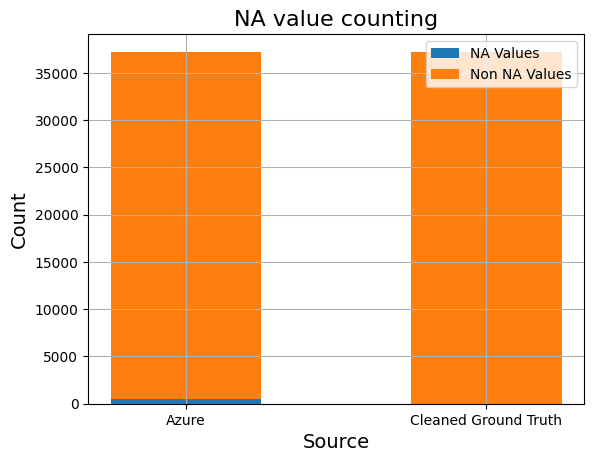

In [15]:
## Null value plots

nonnull_count_large = net_aigenerated_data_azure["NA_Count"].count() - net_aigenerated_data_azure.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_azure.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_azure["NA_Cleaned_Count"].count() - net_aigenerated_data_azure.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_azure.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "Azure",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

plt.show()

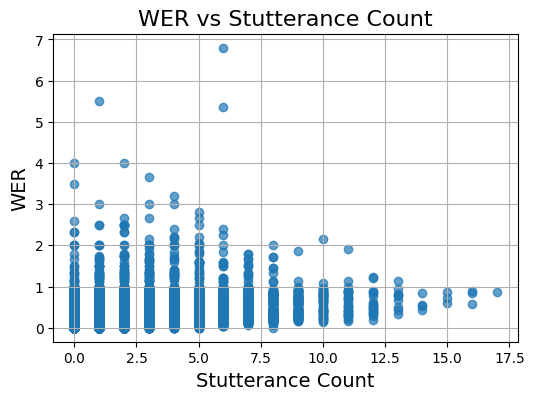

In [16]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

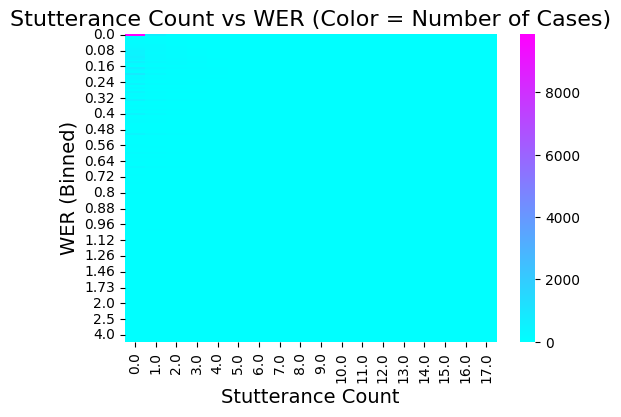

In [17]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_azure['WER_Binned'] = np.round(net_aigenerated_data_azure['WER'], 2)

grouped_data = net_aigenerated_data_azure.groupby(
    ['Stutterance_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stutterance_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [18]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = 0.43824975891281576


***

## ROUGE-N/L Scores (Semantic Evaluation) (Azure)

In [19]:
pip install rouge_chinese jieba

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
from rouge_chinese import Rouge
import jieba

In [21]:
rouge = Rouge()

In [22]:
print_ = True

for index, row in tqdm(net_aigenerated_data_azure.iterrows(), total=len(net_aigenerated_data_azure)):
    
    mask_large = (
        (net_aigenerated_data_azure["Filename"] == row["Filename"]) &
        (net_aigenerated_data_azure["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_azure.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    azure = large_row["Azure"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(azure) or not isinstance(azure, str):
        print("Skipping due to missing or non-string Azure.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(azure)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_azure.loc[mask_large, "rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_azure.loc[mask_large, "rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_azure.loc[mask_large, "rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"] = stutterance_count

        if (print_):
            print(net_aigenerated_data_azure)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/292171.1.ood/jieba.cache
Loading model cost 0.700 seconds.
Prefix dict has been built successfully.
  0%|          | 15/37253 [00:00<26:25, 23.49it/s] 

      Filename   Start_time     End_time  \
0      D0001_A  2081.540000  2109.650000   
1      D0001_A   790.130000   796.580000   
2      D0001_A  1562.083518  1586.220000   
3      D0001_A  2016.780000  2035.673559   
4      D0001_A  1682.670000  1709.110000   
...        ...          ...          ...   
37248    P0070  2586.616000  2589.346000   
37249    P0070  2782.496000  2783.706000   
37250    P0070  2995.296000  2998.116000   
37251    P0070  2604.066000  2606.656000   
37252    P0070  2434.606000  2436.576000   

                                                   Azure       WER  \
0      我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...  0.072165   
1                                                   电视剧。  0.600000   
2                                               这部剧是不怎么？  0.875000   
3                                                很很精准，对。  0.868421   
4                                            一个，那个是，嗯，叫。  0.882353   
...                                                

  0%|          | 57/37253 [00:01<07:43, 80.19it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 101/37253 [00:01<05:15, 117.85it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 129/37253 [00:01<04:51, 127.37it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 186/37253 [00:02<04:33, 135.73it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 801/37253 [00:06<04:22, 138.69it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 886/37253 [00:07<04:24, 137.44it/s]

Skipping due to missing or non-string Azure.


  4%|▎         | 1346/37253 [00:10<04:29, 133.48it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1514/37253 [00:11<04:28, 133.32it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1654/37253 [00:12<04:21, 136.07it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1683/37253 [00:13<04:16, 138.44it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1855/37253 [00:14<04:22, 134.94it/s]

Skipping: One of the rows is empty.


  5%|▌         | 1981/37253 [00:15<04:19, 136.02it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▌         | 2023/37253 [00:15<04:20, 135.17it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2079/37253 [00:16<04:20, 134.89it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2163/37253 [00:16<04:17, 136.07it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2206/37253 [00:16<04:12, 138.95it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2262/37253 [00:17<04:18, 135.43it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2484/37253 [00:19<04:18, 134.76it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2569/37253 [00:19<04:19, 133.57it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2662/37253 [00:20<04:34, 126.24it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  7%|▋         | 2688/37253 [00:20<04:33, 126.23it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2715/37253 [00:20<04:30, 127.89it/s]

Skipping due to missing or non-string Azure.


  8%|▊         | 2832/37253 [00:21<04:38, 123.79it/s]

Skipping due to missing or non-string Azure.


  9%|▊         | 3221/37253 [00:24<04:22, 129.57it/s]

Skipping due to missing or non-string Azure.


  9%|▉         | 3496/37253 [00:27<04:38, 121.24it/s]

Skipping due to missing or non-string Azure.


 10%|▉         | 3718/37253 [00:28<04:04, 137.25it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3762/37253 [00:29<04:00, 139.21it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3804/37253 [00:29<04:03, 137.51it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3846/37253 [00:29<04:06, 135.64it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4004/37253 [00:30<04:14, 130.88it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4044/37253 [00:31<04:35, 120.75it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4083/37253 [00:31<04:37, 119.51it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4121/37253 [00:31<04:33, 121.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4176/37253 [00:32<04:16, 129.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4218/37253 [00:32<04:16, 128.62it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4272/37253 [00:33<04:13, 129.96it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4314/37253 [00:33<04:10, 131.61it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4342/37253 [00:33<04:07, 133.15it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4399/37253 [00:33<04:00, 136.53it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4429/37253 [00:34<03:53, 140.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4594/37253 [00:35<03:52, 140.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4637/37253 [00:35<03:58, 136.90it/s]

Skipping due to missing or non-string Azure.


 13%|█▎        | 4679/37253 [00:35<04:02, 134.48it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 13%|█▎        | 4933/37253 [00:37<03:57, 135.99it/s]

Skipping due to missing or non-string Azure.


 14%|█▎        | 5049/37253 [00:38<03:47, 141.55it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▎        | 5109/37253 [00:39<03:46, 142.03it/s]

Skipping due to missing or non-string Azure.


 14%|█▍        | 5168/37253 [00:39<03:55, 136.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▍        | 5337/37253 [00:40<03:53, 136.59it/s]

Skipping due to missing or non-string Azure.


 15%|█▍        | 5449/37253 [00:41<03:51, 137.26it/s]

Skipping due to missing or non-string Azure.


 15%|█▌        | 5763/37253 [00:44<04:03, 129.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▌        | 5833/37253 [00:44<03:53, 134.32it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5875/37253 [00:44<03:52, 135.13it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5917/37253 [00:45<03:48, 136.87it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5960/37253 [00:45<03:47, 137.66it/s]

Skipping due to missing or non-string Azure.


 16%|█▋        | 6073/37253 [00:46<03:51, 134.80it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▋        | 6101/37253 [00:46<03:54, 133.04it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6157/37253 [00:46<03:52, 133.54it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6215/37253 [00:47<03:44, 138.54it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6259/37253 [00:47<03:39, 141.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6289/37253 [00:47<03:34, 144.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6319/37253 [00:48<03:40, 140.45it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6390/37253 [00:48<03:53, 132.34it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6531/37253 [00:49<03:48, 134.50it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6574/37253 [00:49<03:43, 137.10it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 18%|█▊        | 6758/37253 [00:51<03:48, 133.53it/s]

Skipping due to missing or non-string Azure.


 19%|█▊        | 6926/37253 [00:52<03:49, 131.98it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 6985/37253 [00:53<03:37, 139.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 19%|█▉        | 7157/37253 [00:54<03:36, 139.25it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 7241/37253 [00:54<03:42, 135.02it/s]

Skipping due to missing or non-string Azure.


 20%|█▉        | 7395/37253 [00:56<03:45, 132.50it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7465/37253 [00:56<03:38, 136.31it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7535/37253 [00:57<03:39, 135.41it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7563/37253 [00:57<03:37, 136.63it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7721/37253 [00:58<03:33, 138.21it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7874/37253 [00:59<03:39, 133.82it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7904/37253 [00:59<03:31, 138.53it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 21%|██▏       | 7961/37253 [01:00<03:30, 139.05it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8074/37253 [01:01<03:30, 138.87it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8118/37253 [01:01<03:25, 141.71it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8191/37253 [01:01<03:27, 139.95it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8235/37253 [01:02<03:27, 139.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8291/37253 [01:02<03:38, 132.59it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8333/37253 [01:02<03:35, 133.96it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8361/37253 [01:03<03:31, 136.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8404/37253 [01:03<03:29, 137.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8519/37253 [01:04<03:26, 139.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8632/37253 [01:05<03:30, 135.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 24%|██▎       | 8786/37253 [01:06<03:34, 132.98it/s]

Skipping due to missing or non-string Azure.


 24%|██▎       | 8842/37253 [01:06<03:33, 133.25it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 8968/37253 [01:07<03:32, 132.93it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 9038/37253 [01:08<03:28, 135.45it/s]

Skipping due to missing or non-string Azure.


 25%|██▍       | 9222/37253 [01:09<03:25, 136.23it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 25%|██▌       | 9376/37253 [01:10<03:28, 134.01it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 26%|██▌       | 9517/37253 [01:11<03:23, 136.34it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9615/37253 [01:12<03:27, 133.14it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9686/37253 [01:13<03:24, 135.10it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9770/37253 [01:13<03:21, 136.11it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9798/37253 [01:13<03:23, 135.21it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9854/37253 [01:14<03:26, 132.46it/s]

Skipping due to missing or non-string Azure.


 27%|██▋       | 9953/37253 [01:15<03:20, 136.40it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10082/37253 [01:15<03:14, 139.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10112/37253 [01:16<03:13, 140.61it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10311/37253 [01:17<03:14, 138.76it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10354/37253 [01:17<03:15, 137.71it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10425/37253 [01:18<03:16, 136.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10454/37253 [01:18<03:15, 137.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10496/37253 [01:18<03:20, 133.60it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▊       | 10623/37253 [01:19<03:16, 135.76it/s]

Skipping due to missing or non-string Azure.


 29%|██▊       | 10680/37253 [01:20<03:13, 137.31it/s]

Skipping due to missing or non-string Azure.


 29%|██▊       | 10710/37253 [01:20<03:09, 140.19it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10810/37253 [01:21<03:13, 136.73it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10867/37253 [01:21<03:08, 139.93it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10912/37253 [01:22<03:06, 141.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10927/37253 [01:22<03:13, 135.85it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11194/37253 [01:24<03:15, 133.54it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11278/37253 [01:24<03:12, 134.87it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11306/37253 [01:24<03:09, 136.73it/s]

Skipping due to missing or non-string Azure.


 30%|███       | 11349/37253 [01:25<03:09, 136.55it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11503/37253 [01:26<03:07, 137.53it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11560/37253 [01:26<03:07, 137.14it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11588/37253 [01:27<03:09, 135.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███▏      | 11644/37253 [01:27<03:15, 131.10it/s]

Skipping due to missing or non-string Azure.


 31%|███▏      | 11728/37253 [01:28<03:14, 131.36it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 11979/37253 [01:30<03:06, 135.39it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 12066/37253 [01:30<03:01, 139.13it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12192/37253 [01:31<03:07, 134.00it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12220/37253 [01:31<03:09, 132.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12249/37253 [01:32<03:05, 134.97it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12305/37253 [01:32<03:05, 134.50it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12390/37253 [01:33<03:00, 137.94it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12418/37253 [01:33<03:00, 137.73it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12461/37253 [01:33<02:57, 139.48it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12644/37253 [01:34<03:08, 130.89it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12686/37253 [01:35<03:04, 133.33it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12769/37253 [01:35<03:05, 132.01it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12825/37253 [01:36<03:03, 133.36it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12867/37253 [01:36<03:01, 134.46it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12911/37253 [01:36<02:56, 138.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12939/37253 [01:37<02:58, 136.31it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12981/37253 [01:37<03:02, 133.32it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13052/37253 [01:37<03:01, 133.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▌      | 13108/37253 [01:38<03:03, 131.45it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13164/37253 [01:38<03:05, 130.12it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13236/37253 [01:39<02:57, 135.42it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13450/37253 [01:40<02:53, 137.31it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13508/37253 [01:41<02:51, 138.77it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13538/37253 [01:41<02:46, 142.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 37%|███▋      | 13730/37253 [01:43<02:59, 130.94it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13758/37253 [01:43<02:59, 130.53it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13786/37253 [01:43<02:56, 133.25it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13867/37253 [01:44<03:03, 127.60it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 13989/37253 [01:45<02:59, 129.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14044/37253 [01:45<02:56, 131.47it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14128/37253 [01:46<02:50, 135.37it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14214/37253 [01:46<02:46, 138.21it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14271/37253 [01:47<02:45, 138.84it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14315/37253 [01:47<02:43, 140.13it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14345/37253 [01:47<02:45, 138.01it/s]

Skipping due to missing or non-string Azure.


 39%|███▊      | 14388/37253 [01:48<02:45, 138.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14417/37253 [01:48<02:43, 139.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14459/37253 [01:48<02:48, 135.04it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14502/37253 [01:48<02:48, 135.21it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14687/37253 [01:50<02:45, 136.31it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14745/37253 [01:50<02:40, 139.80it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14842/37253 [01:51<02:54, 128.21it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14882/37253 [01:51<02:53, 128.81it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 14950/37253 [01:52<02:48, 132.63it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 15020/37253 [01:52<02:46, 133.70it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15130/37253 [01:53<02:50, 130.01it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15160/37253 [01:53<02:42, 135.81it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15220/37253 [01:54<02:34, 142.19it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15295/37253 [01:54<02:34, 141.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15340/37253 [01:55<02:38, 138.58it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████▏     | 15384/37253 [01:55<02:37, 138.99it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15486/37253 [01:56<02:35, 139.79it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15531/37253 [01:56<02:33, 141.65it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15663/37253 [01:57<02:33, 140.44it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15708/37253 [01:57<02:30, 142.82it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 15989/37253 [01:59<02:30, 141.64it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16034/37253 [02:00<02:29, 142.17it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16094/37253 [02:00<02:31, 139.76it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16195/37253 [02:01<02:27, 142.35it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16313/37253 [02:02<02:30, 138.90it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16403/37253 [02:02<02:29, 139.78it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16432/37253 [02:02<02:31, 137.31it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16477/37253 [02:03<02:26, 141.88it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▍     | 16745/37253 [02:05<02:29, 136.80it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▌     | 16789/37253 [02:05<02:25, 140.57it/s]

Skipping due to missing or non-string Azure.


 45%|████▌     | 16834/37253 [02:05<02:25, 140.54it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 16951/37253 [02:06<02:26, 138.80it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17161/37253 [02:08<02:22, 141.00it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17191/37253 [02:08<02:23, 140.20it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17475/37253 [02:10<02:20, 140.96it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17535/37253 [02:10<02:16, 144.70it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17580/37253 [02:10<02:15, 145.13it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17610/37253 [02:11<02:15, 144.51it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17715/37253 [02:11<02:18, 141.39it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17820/37253 [02:12<02:17, 141.55it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17865/37253 [02:12<02:14, 144.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17895/37253 [02:13<02:16, 141.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▊     | 18068/37253 [02:14<02:14, 143.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▉     | 18202/37253 [02:15<02:31, 125.44it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18307/37253 [02:16<02:15, 139.97it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18380/37253 [02:16<02:17, 137.52it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18484/37253 [02:17<02:12, 141.98it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18529/37253 [02:17<02:11, 141.97it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18574/37253 [02:18<02:15, 137.95it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18648/37253 [02:18<02:12, 140.43it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18751/37253 [02:19<02:12, 140.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 50%|█████     | 18781/37253 [02:19<02:11, 140.76it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18882/37253 [02:20<02:10, 140.61it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18957/37253 [02:20<02:07, 143.38it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 19032/37253 [02:21<02:09, 140.84it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████     | 19092/37253 [02:21<02:09, 140.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19137/37253 [02:22<02:08, 141.42it/s]

Skipping due to missing or non-string Azure.


 51%|█████▏    | 19167/37253 [02:22<02:07, 142.37it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19255/37253 [02:23<02:06, 141.83it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19330/37253 [02:23<02:04, 143.41it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19598/37253 [02:25<02:04, 142.22it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19673/37253 [02:25<02:04, 141.20it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19703/37253 [02:26<02:04, 141.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19746/37253 [02:26<02:07, 137.55it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19895/37253 [02:27<02:03, 140.03it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19969/37253 [02:28<02:04, 138.47it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19999/37253 [02:28<02:00, 142.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20030/37253 [02:28<01:58, 145.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20089/37253 [02:28<02:03, 139.36it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20235/37253 [02:29<02:04, 136.58it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20295/37253 [02:30<02:01, 139.40it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20323/37253 [02:30<02:02, 138.11it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20353/37253 [02:30<02:00, 140.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20501/37253 [02:31<01:59, 140.42it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20635/37253 [02:32<01:57, 141.61it/s]

Skipping due to missing or non-string Azure.


 56%|█████▋    | 21000/37253 [02:35<01:57, 138.71it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21056/37253 [02:35<01:58, 136.50it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21112/37253 [02:36<01:58, 136.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21240/37253 [02:37<01:55, 138.12it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21310/37253 [02:37<01:57, 136.13it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21457/37253 [02:38<01:51, 141.07it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21547/37253 [02:39<01:52, 140.11it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 58%|█████▊    | 21723/37253 [02:40<01:51, 139.29it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21781/37253 [02:41<01:54, 135.16it/s]

Skipping due to missing or non-string Azure.


 59%|█████▊    | 21854/37253 [02:41<01:49, 140.97it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21899/37253 [02:41<01:48, 141.45it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21974/37253 [02:42<01:47, 141.49it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22019/37253 [02:42<01:46, 142.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22094/37253 [02:43<01:46, 142.10it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22139/37253 [02:43<01:45, 143.25it/s]

Skipping due to missing or non-string Azure.


 60%|█████▉    | 22271/37253 [02:44<01:50, 135.26it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22404/37253 [02:45<01:43, 142.90it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22524/37253 [02:46<01:44, 140.95it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22734/37253 [02:47<01:43, 140.36it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22779/37253 [02:48<01:41, 141.99it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22809/37253 [02:48<01:43, 139.46it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 22929/37253 [02:49<01:40, 142.52it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23019/37253 [02:49<01:40, 141.81it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23109/37253 [02:50<01:40, 140.87it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23154/37253 [02:50<01:39, 142.26it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23303/37253 [02:51<01:39, 139.81it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23332/37253 [02:52<01:40, 139.05it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23375/37253 [02:52<01:39, 139.56it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 63%|██████▎   | 23435/37253 [02:52<01:38, 140.77it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23480/37253 [02:53<01:36, 143.10it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23540/37253 [02:53<01:36, 142.06it/s]

Skipping due to missing or non-string Azure.


 64%|██████▎   | 23747/37253 [02:55<01:37, 138.96it/s]

Skipping due to missing or non-string Azure.


 64%|██████▍   | 23970/37253 [02:56<01:31, 144.62it/s]

Skipping due to missing or non-string Azure.


 65%|██████▍   | 24135/37253 [02:57<01:31, 143.32it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24225/37253 [02:58<01:31, 141.67it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24300/37253 [02:58<01:30, 143.33it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24375/37253 [02:59<01:31, 141.38it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24717/37253 [03:01<01:32, 135.95it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24759/37253 [03:02<01:37, 128.67it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 67%|██████▋   | 24842/37253 [03:02<01:33, 132.11it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 24982/37253 [03:03<01:30, 136.13it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 25095/37253 [03:04<01:31, 133.53it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 68%|██████▊   | 25279/37253 [03:06<01:25, 140.18it/s]

Skipping due to missing or non-string Azure.


 68%|██████▊   | 25382/37253 [03:06<01:25, 138.67it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25530/37253 [03:07<01:23, 140.40it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25560/37253 [03:08<01:23, 140.38it/s]

Skipping due to missing or non-string Azure.


 69%|██████▉   | 25822/37253 [03:10<01:21, 139.99it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26214/37253 [03:12<01:19, 139.03it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26258/37253 [03:13<01:17, 141.16it/s]

Skipping due to missing or non-string Azure.


 71%|███████   | 26452/37253 [03:14<01:15, 142.54it/s]

Skipping due to missing or non-string Azure.


 72%|███████▏  | 26958/37253 [03:18<01:13, 141.00it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27078/37253 [03:19<01:12, 141.31it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27151/37253 [03:19<01:12, 138.99it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27336/37253 [03:20<01:10, 139.74it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 74%|███████▎  | 27396/37253 [03:21<01:08, 143.19it/s]

Skipping due to missing or non-string Azure.


 74%|███████▍  | 27531/37253 [03:22<01:08, 141.67it/s]

Skipping due to missing or non-string Azure.


 75%|███████▍  | 27857/37253 [03:24<01:06, 142.12it/s]

Skipping due to missing or non-string Azure.


 76%|███████▌  | 28229/37253 [03:27<01:06, 136.43it/s]

Skipping due to missing or non-string Azure.


 78%|███████▊  | 29241/37253 [03:34<00:57, 140.16it/s]

Skipping due to missing or non-string Azure.


 80%|███████▉  | 29627/37253 [03:37<00:55, 138.36it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30073/37253 [03:40<00:51, 138.20it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30102/37253 [03:40<00:51, 138.60it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30161/37253 [03:40<00:49, 141.91it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30191/37253 [03:41<00:49, 142.19it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30236/37253 [03:41<00:49, 141.81it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████  | 30266/37253 [03:41<00:49, 142.05it/s]

Skipping due to missing or non-string Azure.


 81%|████████▏ | 30326/37253 [03:42<00:49, 141.27it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30386/37253 [03:42<00:47, 143.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30431/37253 [03:42<00:47, 142.76it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30491/37253 [03:43<00:47, 142.44it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30578/37253 [03:43<00:48, 139.00it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30653/37253 [03:44<00:45, 144.25it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30683/37253 [03:44<00:45, 144.11it/s]

Skipping due to missing or non-string Azure.


 88%|████████▊ | 32698/37253 [03:58<00:31, 143.18it/s]

Skipping due to missing or non-string Azure.


 90%|█████████ | 33702/37253 [04:06<00:24, 143.25it/s]

Skipping due to missing or non-string Azure.


 91%|█████████ | 33987/37253 [04:08<00:22, 142.61it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34032/37253 [04:08<00:22, 143.77it/s]

Skipping due to missing or non-string Azure.
Skipping: One of the rows is empty.


 92%|█████████▏| 34107/37253 [04:08<00:21, 144.13it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34601/37253 [04:12<00:19, 134.00it/s]

Skipping: One of the rows is empty.


 94%|█████████▎| 34846/37253 [04:14<00:17, 137.14it/s]

Skipping due to missing or non-string Azure.


 94%|█████████▍| 34960/37253 [04:15<00:16, 139.37it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35858/37253 [04:21<00:10, 132.49it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35886/37253 [04:21<00:10, 131.73it/s]

Skipping due to missing or non-string Azure.


100%|██████████| 37253/37253 [04:31<00:00, 137.19it/s]


In [23]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,WER_Binned,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...,0.072165,1.0,470,0,0.07,0.948718,0.973684,0.961039,0.850000,0.836066,0.842975,0.942857,0.942857,0.942857
1,D0001_A,790.130000,796.580000,电视剧。,0.600000,1.0,470,0,0.60,1.000000,0.285714,0.444444,0.000000,0.000000,0.000000,1.000000,0.285714,0.444444
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？,0.875000,10.0,470,0,0.88,0.750000,0.096774,0.171429,0.666667,0.050000,0.093023,0.750000,0.071429,0.130435
3,D0001_A,2016.780000,2035.673559,很很精准，对。,0.868421,7.0,470,0,0.87,0.800000,0.200000,0.320000,0.600000,0.107143,0.181818,0.666667,0.129032,0.216216
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。,0.882353,8.0,470,0,0.88,1.000000,0.212121,0.350000,0.125000,0.022727,0.038462,0.777778,0.142857,0.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。,0.090909,0.0,470,0,0.09,0.857143,1.000000,0.923077,0.666667,0.800000,0.727273,0.857143,1.000000,0.923077
37249,P0070,2782.496000,2783.706000,杨幂的电影。,0.000000,0.0,470,0,0.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？,0.200000,0.0,470,0,0.20,0.625000,0.625000,0.625000,0.428571,0.375000,0.400000,0.625000,0.555556,0.588235
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。,0.166667,0.0,470,0,0.17,0.833333,0.833333,0.833333,0.600000,0.600000,0.600000,0.833333,0.833333,0.833333


In [24]:
# net_aigenerated_data_azure.to_csv('net_aigenerated_data_azure_performance_data.csv', sep=',')

***

## Visualization of Relationship between Stutterance Count and Rouge Scores (Azure)

In [25]:
## Load data from csv if starting here

# net_aigenerated_data_azure = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-azure/net_aigenerated_data_azure_performance_data.csv', delimiter=',')

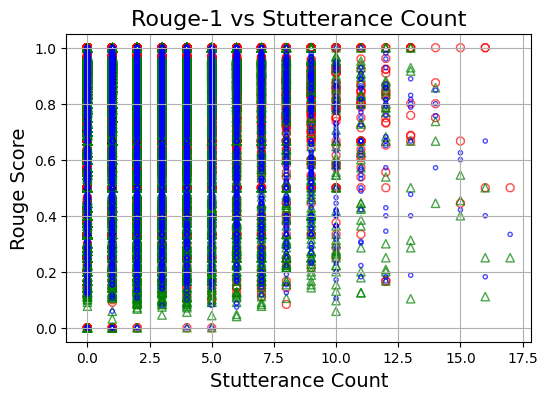

In [26]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge1-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge1-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

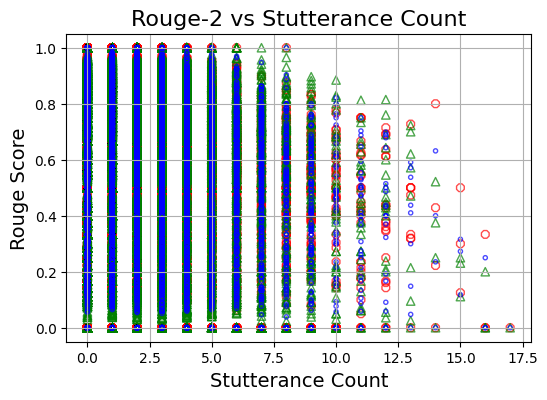

In [27]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge2-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge2-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

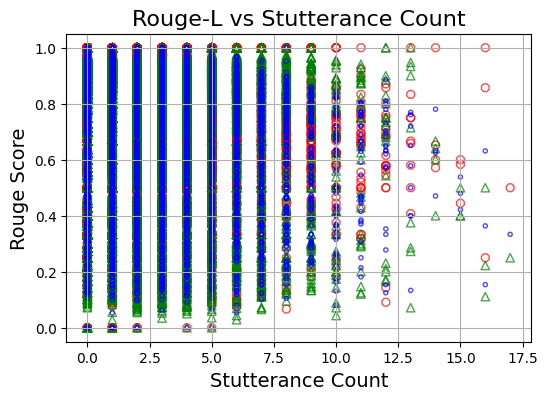

In [28]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rougel-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rougel-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores (Azure)

In [29]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rouge1-precision'])
print(f"p-value [stuttering count & rouge-1 precision] = {p}")
print(f"rho [stuttering count & rouge-1 precision] = {rho}")

rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rouge1-recall'])
print(f"p-value [stuttering count & rouge-1 recall] = {p}")
print(f"rho [stuttering count & rouge-1 recall] = {rho}")

rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")

p-value [stuttering count & rouge-1 precision] = 1.0095000362889638e-152
rho [stuttering count & rouge-1 precision] = -0.13662674459631924
p-value [stuttering count & rouge-1 recall] = 1.302145460028583e-288
rho [stuttering count & rouge-1 recall] = -0.1876371806735333
p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = -0.2170199655911308


***
***
***